### TODO's for tomorrow###

1. Run ensemble regression for ALL features then sort by feature importance
2. Remove duplicated features (2p vs 2pa etc)
3. Get feature importance again(?)
4. Run variance inflation factor calculation and remove highest variance features 1 by 1 until you get all below 5

In [65]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [5]:
# Training Data
season_stats = pd.read_csv('Seasons_Stats.csv')
season_stats = season_stats.drop(['blanl', 'blank2', 'Unnamed: 0'], axis=1)
season_stats = season_stats[season_stats.Tm.str.contains('TOT') == False]
# Maybe use this for classification?
season_stats['MVP_Candidate'] = np.where(season_stats['MVPSHARES'] > 0, 'Yes', 'No')
season_stats['Player'] = season_stats['Player'].astype(str).str.replace('*', '')
season_stats['PPG'] = season_stats['PTS'] / season_stats['G']
season_stats['ASTPG'] = season_stats['AST'] / season_stats['G']
season_stats['STLPG'] = season_stats['STL'] / season_stats['G']
season_stats['BLKPG'] = season_stats['BLK'] / season_stats['G']
season_stats['PFPG'] = season_stats['PF'] / season_stats['G']
season_stats['TRPG'] = season_stats['TRB'] / season_stats['G']
season_stats['ORPG'] = season_stats['ORB'] / season_stats['G']
season_stats['DRPG'] = season_stats['DRB'] / season_stats['G']
season_stats['MPPG'] = season_stats['MP'] / season_stats['G']
season_stats['TOVPG'] = season_stats['TOV'] / season_stats['G']
#season_stats = season_stats.drop(['PTS', 'AST', 'STL', 'BLK', 'PF', 'TRB', 'ORB', 'DRB', 'MP',
                              #  'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'FG%', '3P%', 'eFG%',
                               #  '2P%', 'ORB%', 'DRB%', 'WS/48', 'TRB%', 'AST%', 'STL%', 
                              # 'BLK%', 'OWS'], axis=1)
season_stats = season_stats[season_stats['G'] >= 41.0]
season_stats = season_stats[season_stats['MPPG'] >= 25.0]
season_stats['Year'] = season_stats['Year'].astype(int)

season_stats = season_stats.dropna()

In [6]:
season_stats.head()

,Year,Decade,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MVPSHARES,MVP,TMWL%,MVP_Candidate,PPG,ASTPG,STLPG,BLKPG,PFPG,TRPG,ORPG,DRPG,MPPG,TOVPG
5730,1980,80's,Tiny Archibald,PG,31.0,BOS,80.0,80.0,2864.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,383.0,794.0,0.482,4.0,18.0,0.222,379.0,776.0,0.488,0.485,361.0,435.0,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,0.000,0,0.744,No,14.137500,8.387500,1.325000,0.125000,2.725000,2.462500,0.737500,1.725000,35.800000,3.025000
5748,1980,80's,Larry Bird,PF,23.0,BOS,82.0,82.0,2955.0,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0,25.3,5.6,5.6,11.2,0.182,2.7,2.6,5.3,5.4,693.0,1463.0,0.474,58.0,143.0,0.406,635.0,1320.0,0.481,0.494,301.0,360.0,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,1745.0,0.000,0,0.744,No,21.280488,4.512195,1.743902,0.646341,3.402439,10.390244,2.634146,7.756098,36.036585,3.207317
5802,1980,80's,Dave Cowens,C,31.0,BOS,66.0,55.0,2159.0,14.8,0.477,0.013,0.131,6.6,20.7,13.8,13.4,1.5,1.6,9.9,20.1,1.9,3.6,5.4,0.121,-0.7,2.0,1.4,1.8,422.0,932.0,0.453,1.0,12.0,0.083,421.0,920.0,0.458,0.453,95.0,122.0,0.779,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0,0.000,0,0.744,No,14.242424,3.121212,1.045455,0.924242,3.272727,8.090909,1.909091,6.181818,32.712121,1.636364
5835,1980,80's,Chris Ford,SG,31.0,BOS,73.0,73.0,2115.0,13.0,0.537,0.231,0.161,4.1,5.4,4.8,13.5,2.5,0.7,12.2,16.2,2.9,2.6,5.6,0.126,1.4,0.8,2.2,2.2,330.0,709.0,0.465,70.0,164.0,0.427,260.0,545.0,0.477,0.515,86.0,114.0,0.754,77.0,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,0.000,0,0.744,No,11.178082,2.945205,1.520548,0.369863,2.438356,2.479452,1.054795,1.424658,28.972603,1.438356
6091,1981,80's,Tiny Archibald,PG,32.0,BOS,80.0,72.0,2820.0,14.3,0.582,0.012,0.547,1.5,5.4,3.6,28.5,1.3,0.4,21.8,17.5,4.6,2.3,6.9,0.118,0.4,-1.6,-1.3,0.5,382.0,766.0,0.499,0.0,9.0,0.000,382.0,757.0,0.505,0.499,342.0,419.0,0.816,36.0,140.0,176.0,618.0,75.0,18.0,265.0,201.0,1106.0,0.046,0,0.756,Yes,13.825000,7.725000,0.937500,0.225000,2.512500,2.200000,0.450000,1.750000,35.250000,3.312500


In [7]:
mvp = season_stats[season_stats['MVP'] == 1]
mvp_candidate = season_stats[season_stats['MVPSHARES'] > 0]
#mvp['Decade']
mvp_80 = mvp[(mvp['Year'] >= 1980.0) & (mvp['Year'] < 1990.0)]
mvp_90 = mvp[(mvp['Year'] >= 1990.0) & (mvp['Year'] < 2000.0)]
mvp_00 = mvp[(mvp['Year'] >= 2000.0) & (mvp['Year'] < 2010.0)]
mvp_10 = mvp[mvp['Year'] >= 2010.0]

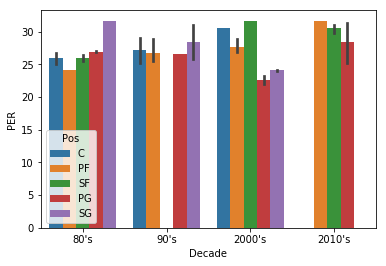

In [8]:
ax = sns.barplot(x='Decade', y='PER', hue='Pos', data=mvp)

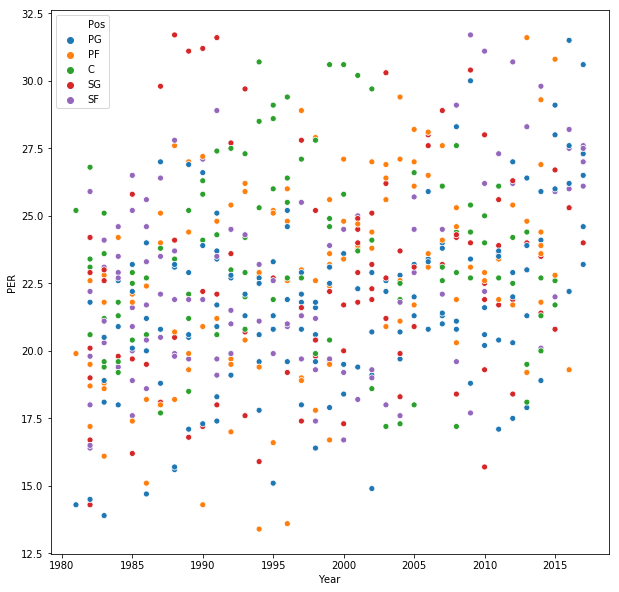

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='Year', y='PER', hue='Pos', data=mvp_candidate)

0.15999999999999998

In [55]:
from sklearn.feature_selection import VarianceThreshold

X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)
def variance_threshold_selector(data, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]


#variance_threshold_selector(X, 10)
X

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TMWL%,PPG,ASTPG,STLPG,BLKPG,PFPG,TRPG,ORPG,DRPG,MPPG,TOVPG
5730,1980,31.0,80.0,80.0,2864.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,383.0,794.0,0.482,4.0,18.0,0.222,379.0,776.0,0.488,0.485,361.0,435.0,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,0.744,14.137500,8.387500,1.325000,0.125000,2.725000,2.462500,0.737500,1.725000,35.800000,3.025000
5748,1980,23.0,82.0,82.0,2955.0,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0,25.3,5.6,5.6,11.2,0.182,2.7,2.6,5.3,5.4,693.0,1463.0,0.474,58.0,143.0,0.406,635.0,1320.0,0.481,0.494,301.0,360.0,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,1745.0,0.744,21.280488,4.512195,1.743902,0.646341,3.402439,10.390244,2.634146,7.756098,36.036585,3.207317
5802,1980,31.0,66.0,55.0,2159.0,14.8,0.477,0.013,0.131,6.6,20.7,13.8,13.4,1.5,1.6,9.9,20.1,1.9,3.6,5.4,0.121,-0.7,2.0,1.4,1.8,422.0,932.0,0.453,1.0,12.0,0.083,421.0,920.0,0.458,0.453,95.0,122.0,0.779,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0,0.744,14.242424,3.121212,1.045455,0.924242,3.272727,8.090909,1.909091,6.181818,32.712121,1.636364
5835,1980,31.0,73.0,73.0,2115.0,13.0,0.537,0.231,0.161,4.1,5.4,4.8,13.5,2.5,0.7,12.2,16.2,2.9,2.6,5.6,0.126,1.4,0.8,2.2,2.2,330.0,709.0,0.465,70.0,164.0,0.427,260.0,545.0,0.477,0.515,86.0,114.0,0.754,77.0,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,0.744,11.178082,2.945205,1.520548,0.369863,2.438356,2.479452,1.054795,1.424658,28.972603,1.438356
6091,1981,32.0,80.0,72.0,2820.0,14.3,0.582,0.012,0.547,1.5,5.4,3.6,28.5,1.3,0.4,21.8,17.5,4.6,2.3,6.9,0.118,0.4,-1.6,-1.3,0.5,382.0,766.0,0.499,0.0,9.0,0.000,382.0,757.0,0.505,0.499,342.0,419.0,0.816,36.0,140.0,176.0,618.0,75.0,18.0,265.0,201.0,1106.0,0.756,13.825000,7.725000,0.937500,0.225000,2.512500,2.200000,0.450000,1.750000,35.250000,3.312500
6100,1981,24.0,82.0,82.0,3239.0,19.9,0.528,0.049,0.218,7.0,23.8,15.7,20.4,2.4,1.1,14.9,24.3,4.7,6.1,10.8,0.160,2.1,3.0,5.1,5.8,719.0,1503.0,0.478,20.0,74.0,0.270,699.0,1429.0,0.489,0.485,283.0,328.0,0.863,191.0,704.0,895.0,451.0,161.0,63.0,289.0,239.0,1741.0,0.756,21.231707,5.500000,1.963415,0.768293,2.914634,10.914634,2.329268,8.585366,39.500000,3.524390
6182,1981,32.0,82.0,75.0,2723.0,8.8,0.488,0.154,0.123,3.1,3.7,3.4,13.7,1.7,0.5,14.6,13.0,1.3,2.4,3.7,0.066,-0.7,0.2,-0.5,1.0,314.0,707.0,0.444,36.0,109.0,0.330,278.0,598.0,0.465,0.470,64.0,87.0,0.736,72.0,91.0,163.0,295.0,100.0,23.0,127.0,212.0,728.0,0.756,8.878049,3.597561,1.219512,0.280488,2.585366,1.987805,0.878049,1.109756,33.207317,1.548780
6302,1981,25.0,81.0,81.0,2730.0,17.6,0.651,0.001,0.600,9.7,12.1,11.0,10.8,1.4,1.4,16.0,16.8,7.6,3.3,11.0,0.193,3.5,1.3,4.8,4.7,441.0,750.0,0.588,0.0,1.0,0.000,441.0,749.0,0.589,0.588,352.0,450.0,0.782,222.0,303.0,525.0,219.0,79.0,68.0,180.0,256.0,1234.0,0.756,15.234568,2.703704,0.975309,0.839506,3.160494,6.481481,2.740741,3.740741,33.703704,2.222222
6343,1981,27.0,82.0,78.0,2298.0,25.2,0.579,0.001,0.340,12.7,25.3,19.3,10.0,1.7,5.1,12.5,27.1,6.0,4.9,10.9,0.228,2.7,2.3,5.0,4.0,635.0,1166.0,0.545,0.0,1.0,0.000,635.0,1165.0,0.545,0.545,282.0,397.0,0.710,245.0,532.0,777.0,144.0,81.0,214.0,191.0,310.0,1552.0,0.756,18.926829,1.756098,0.987805,2.609756,3.780488,9.475610,2.987805,6.487805,28.024390,2.329268
6449,1982,34.0,76.0,76.0,2677.0,23.4,0.608,0.002,0.340,7.3,19.1,13.4,11.9,1.1,4.1,13.3,25.6,6.9,3.9,10.7,0.192,2.9,1.4,4.3,4.2,753.0,1301.0,0.579,0.0,3.0,0.000,753.0,1298.0,0.580,0.579,312.0,442.0,0.706,172.0,487.0,659.0,225.0,63.0,207.0,230.0,224.0,1818.0,0.695,23.921053,2.960526,0.828947,2.723684,2.947368,8.671053,2.263158,6.407895,35.223684,3.026316


In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

df = season_stats.drop(feat_todrop, axis=1)
X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i)
         for i in range (X.shape[1])],
          index=X.columns)

const    447.070215
Age        1.147916
PER        3.143071
FG%        4.242094
3P%        1.794510
eFG%       3.301261
FT%        1.627111
TMWL%      1.282464
ASTPG      2.965515
STLPG      1.780650
BLKPG      2.068186
PFPG       1.759423
TRPG       3.406359
MPPG       2.019030
TOVPG      2.946994
dtype: float64

In [24]:
# Test Data
season_2018 = pd.read_csv('2018_season.csv')
season_2018 = season_2018.drop(['blanl', 'blank2'], axis=1)
season_2018 = season_2018[season_2018.Tm.str.contains('TOT') == False]
# Maybe use this for classification?
season_2018['MVP_Candidate'] = np.where(season_2018['MVPSHARES'] > 0, 'Yes', 'No')
season_2018['Player'] = season_2018['Player'].astype(str).str.replace('*', '')
season_2018['PPG'] = season_2018['PTS'] / season_2018['G']
season_2018['ASTPG'] = season_2018['AST'] / season_2018['G']
season_2018['STLPG'] = season_2018['STL'] / season_2018['G']
season_2018['BLKPG'] = season_2018['BLK'] / season_2018['G']
season_2018['PFPG'] = season_2018['PF'] / season_2018['G']
season_2018['TRPG'] = season_2018['TRB'] / season_2018['G']
# season_2018['ORPG'] = season_2018['ORB'] / season_2018['G']
# season_2018['DRPG'] = season_2018['DRB'] / season_2018['G']
season_2018['MPPG'] = season_2018['MP'] / season_2018['G']
#season_2018 = season_2018.drop(['PTS', 'AST', 'STL', 'BLK', 'PF', 'TRB', 'ORB', 'DRB', 'MP',
                                # 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'FG%', '3P%', 'eFG%',
                                # '2P%', 'WS', 'ORB%', 'DRB%', 'WS/48', 'TRB%', 'AST%', 'STL%', 
                               # 'BLK%', 'USG%', 'OWS', 'VORP'], axis=1)
season_2018 = season_2018[season_2018['G'] >= 41.0]
season_2018 = season_2018[season_2018['MPPG'] >= 25.0]
season_2018 = season_2018.dropna()

In [10]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
y = season_stats['MVPSHARES'].values.reshape(-1,1)
X = season_stats[['PPG', 'WS', 'TMWL%', 'PER']]
regr.fit(X, y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, y))


Coefficients: 
 [[0.01056777 0.00268662 0.00557622]]

Intercept: 
 [-0.13552793]

R-squared:
0.2546116571950968


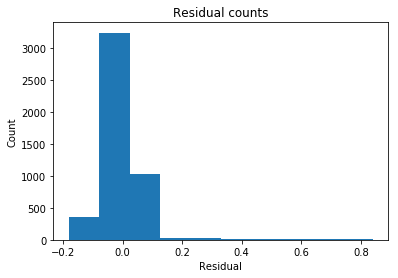

In [16]:
predicted = regr.predict(X).ravel()
actual = season_stats['MVPSHARES']

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

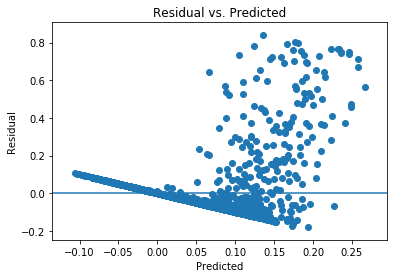

In [17]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [18]:
correlation_matrix = X.corr()
display(correlation_matrix)

,WS,TMWL%,PER
WS,1.000000,0.538729,0.800665
TMWL%,0.538729,1.000000,0.265718
PER,0.800665,0.265718,1.000000


In [ ]:
corrmap = season_stats[mvp_features].corr().abs()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corrmap)

In [62]:
from sklearn.model_selection import train_test_split

mvp_features = ['Age', 'WS', 'G', 'GS', 'PER', 'TS%', '3PAr', 'FTr', 'TOV%', 'DWS', 'OBPM', 'DBPM', 'BPM', 'FT%', 'TOV', 'TMWL%', 
                'PPG', 'ASTPG', 'STLPG', 'BLKPG', 'PFPG', 'TRPG', 'MPPG', '2P%', 'ORB%', 'DRB%', 'WS/48', 'TRB%', 'AST%', 'STL%', 
                    'BLK%', 'USG%', 'OWS', 'VORP', 'USG%']

y = season_stats['MVPSHARES']
X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [41]:

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:

print(cross_val_score(rf, X_test, y_test, cv=10))
print(rf.score(X_test,y_test))

[0.7520869  0.62491585 0.839665   0.70018815 0.86813076 0.20892028
 0.75600267 0.5819127  0.79328286 0.90419521]
0.7476937572376281


In [48]:
# TO DO: train new rf model with just the top 10 features from here
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = rf.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

,features,scores
19,WS,0.339956
5,PER,0.132344
47,TMWL%,0.109458
20,WS/48,0.034585
26,FGA,0.026657
16,USG%,0.024591
18,DWS,0.019728
32,2PA,0.018130
24,VORP,0.017436
25,FG,0.016021


In [53]:
rf_features = ['WS', 'PER', 'USG%', 'TMWL%', 'WS/48', 'FGA', 'DWS', '2PA',
              'VORP', 'FG']

y = season_stats['MVPSHARES']
X = season_stats[rf_features]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [54]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [55]:
print(cross_val_score(rf, X_test, y_test, cv=10))
print(rf.score(X_test,y_test))

[0.72989628 0.72559031 0.84244225 0.71293863 0.88814379 0.21747517
 0.63963672 0.5527641  0.77303009 0.89905778]
0.730955778323489


In [151]:
from sklearn.feature_selection import SelectKBest, f_regression

y = season_stats['MVPSHARES']
X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)
print(X.shape)
X_new = SelectKBest(f_regression, k=20).fit_transform(X, y)
print(X_new.shape)

(4750, 58)
(4750, 20)


In [79]:
feat_todrop = ['Year', 'Tm', 'Pos', 'Player', 'Decade', 'OWS', 'DWS', 'ORB%', 'DRB%', 'MP', 'G', 'GS', 'OBPM', 'DBPM',
              '3PAr', 'FTr', 'MVPSHARES', 'MVP', 'MVP_Candidate', 'TRB%', 'AST%', 'BLK%', 'TOV%', 'WS',
              'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'STL%', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', '2P%',
              'AST', 'STL', 'BLK', 'TOV', 'WS/48', 'PTS', 'PF', 'BPM', 'VORP', 'ORPG', 'DRPG', 'TS%', 'USG%', 'PPG']
corr = season_stats.drop(feat_todrop, axis=1).corr()
corr

,Age,PER,FG%,3P%,eFG%,FT%,TMWL%,ASTPG,STLPG,BLKPG,PFPG,TRPG,MPPG,TOVPG
Age,1.000000,-0.020600,-0.038437,0.057567,0.046101,0.129227,0.247872,0.028828,-0.084885,-0.081346,-0.151037,-0.047920,-0.068130,-0.153442
PER,-0.020600,1.000000,0.436169,-0.020183,0.344199,0.147496,0.265718,0.295482,0.314614,0.331834,0.078285,0.424512,0.513373,0.525049
FG%,-0.038437,0.436169,1.000000,-0.364006,0.714046,-0.240735,0.222326,-0.165775,-0.104346,0.396609,0.320488,0.480579,0.092658,0.100797
3P%,0.057567,-0.020183,-0.364006,1.000000,0.085643,0.344458,0.066845,0.208320,0.136389,-0.361526,-0.360757,-0.406211,0.089122,-0.045040
eFG%,0.046101,0.344199,0.714046,0.085643,1.000000,-0.018401,0.321492,-0.111927,-0.091454,0.146723,0.017355,0.170705,0.062982,-0.080604
FT%,0.129227,0.147496,-0.240735,0.344458,-0.018401,1.000000,0.051412,0.252846,0.073914,-0.359860,-0.295755,-0.391271,0.126499,0.072869
TMWL%,0.247872,0.265718,0.222326,0.066845,0.321492,0.051412,1.000000,0.094591,0.093092,0.065687,-0.069227,0.069845,0.094505,-0.033834
ASTPG,0.028828,0.295482,-0.165775,0.208320,-0.111927,0.252846,0.094591,1.000000,0.572440,-0.330986,-0.230408,-0.331820,0.364295,0.578164
STLPG,-0.084885,0.314614,-0.104346,0.136389,-0.091454,0.073914,0.093092,0.572440,1.000000,-0.131696,-0.005371,-0.119976,0.402685,0.421302
BLKPG,-0.081346,0.331834,0.396609,-0.361526,0.146723,-0.359860,0.065687,-0.330986,-0.131696,1.000000,0.429251,0.660961,0.120453,0.082153


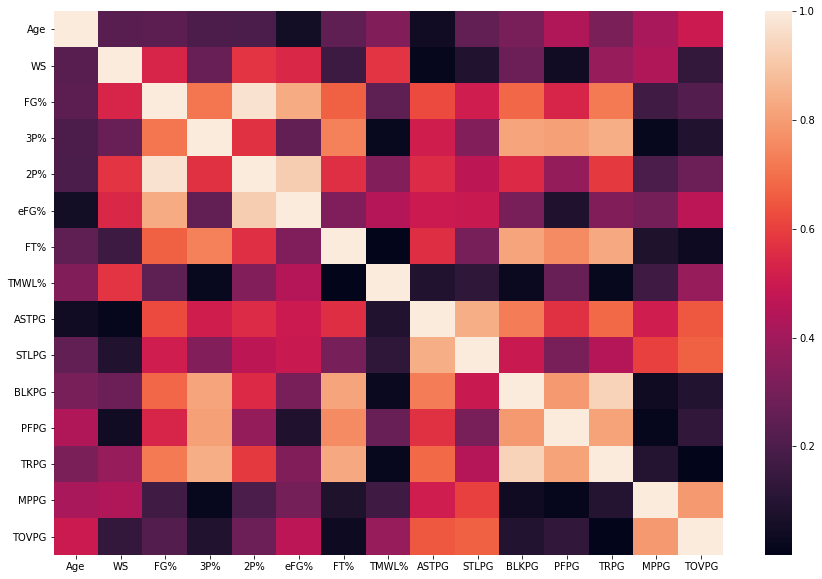

In [70]:
corrmap = corr.corr().abs()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corrmap)

In [82]:
y = season_stats['MVPSHARES']
X = season_stats.drop(feat_todrop, axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [83]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [84]:
print(cross_val_score(rf, X_test, y_test, cv=10))
print(rf.score(X_test,y_test))

[0.62497167 0.63415381 0.79077167 0.6165185  0.87825944 0.32881488
 0.47596121 0.68909497 0.78707516 0.84358695]
0.7223337922504255


In [88]:
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = rf.feature_importances_

importance.sort_values('scores', ascending=False)

,features,scores
1,PER,0.482323
6,TMWL%,0.204287
12,MPPG,0.064214
13,TOVPG,0.047748
10,PFPG,0.029818
4,eFG%,0.026112
7,ASTPG,0.022268
11,TRPG,0.021481
5,FT%,0.021240
2,FG%,0.020400


In [133]:
high_corr_var = np.where(corr>0.5)
high_corr_var=[(corrmap.index[x],corrmap.columns[y]) 
               for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('WS', 'TMWL%'),
 ('WS', 'PPG'),
 ('WS', 'MPPG'),
 ('FG%', '2P%'),
 ('FG%', 'eFG%'),
 ('2P%', 'eFG%'),
 ('PPG', 'MPPG'),
 ('PPG', 'TOVPG'),
 ('ASTPG', 'STLPG'),
 ('ASTPG', 'TOVPG'),
 ('BLKPG', 'TRPG'),
 ('MPPG', 'TOVPG')]

In [ ]:
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = clf.feature_importances_

importance.sort_values('scores', ascending=False)

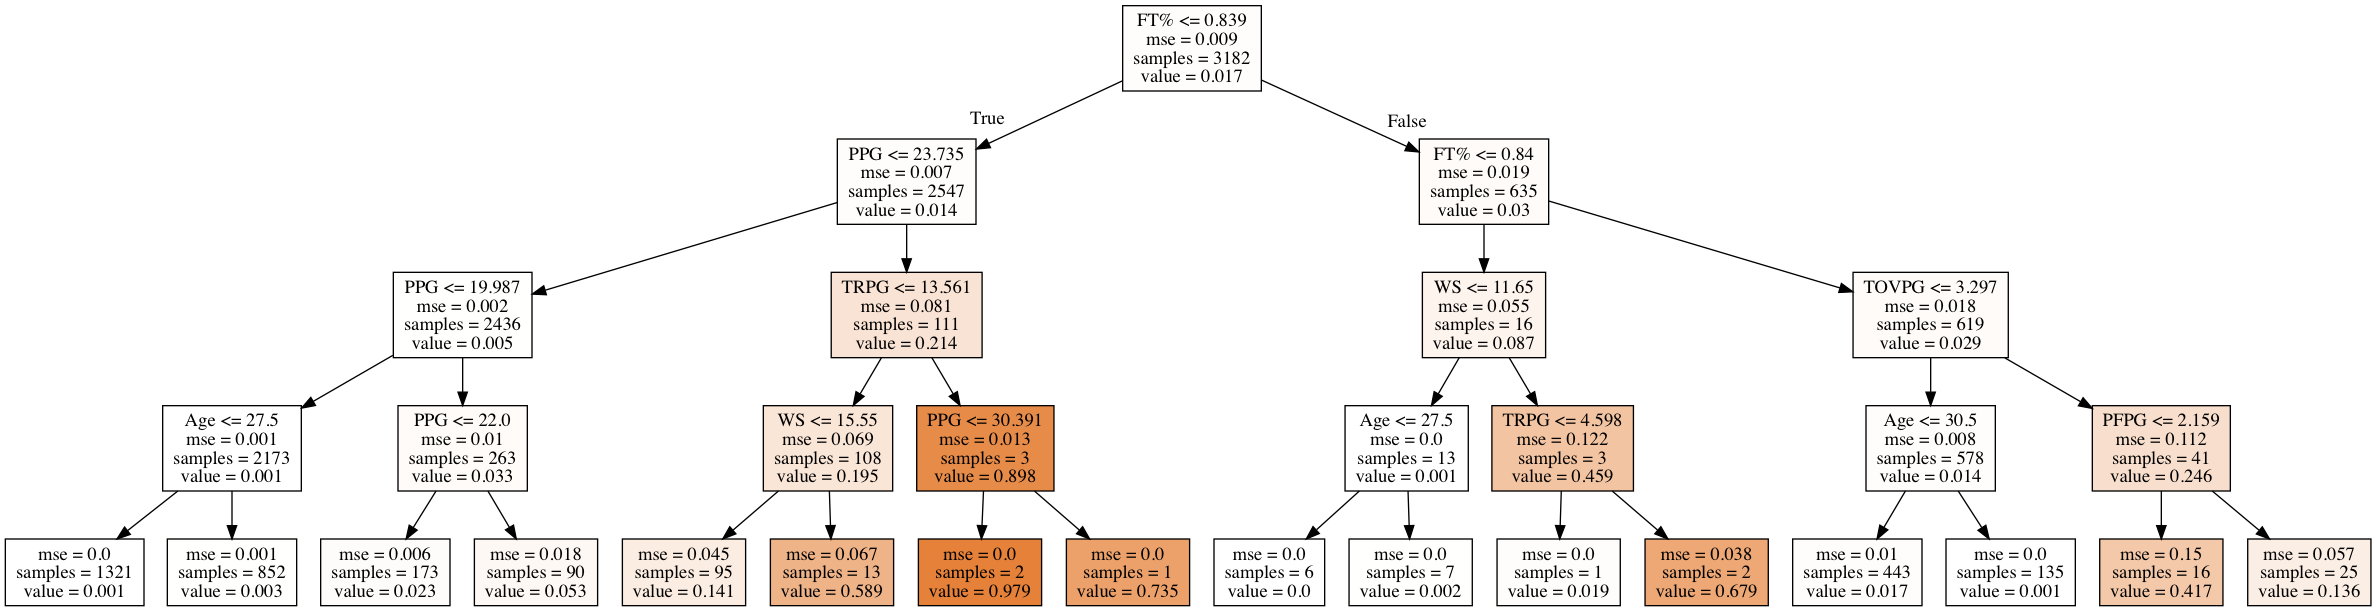

In [136]:
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

clf = tree.DecisionTreeRegressor(
    max_features=1,
    max_depth=4)
clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(
    clf, out_file=None,
    feature_names=X_train.columns,
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [137]:

print(cross_val_score(clf, X_test, y_test, cv=10))
print(clf.score(X_test,y_test))

[ 0.33138036  0.13315022 -0.00949338  0.49743062  0.20357916 -0.15057939
 -0.53012357  0.27769955  0.13551877  0.57167337]
0.3802699324445131


In [24]:
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = clf.feature_importances_

importance.sort_values('scores', ascending=False)

,features,scores
1,WS,0.416320
15,TMWL%,0.140876
16,PPG,0.081999
4,PER,0.049878
7,FTr,0.046218
14,TOV,0.036468
12,BPM,0.034627
24,ORB%,0.034614
31,USG%,0.022067
33,VORP,0.020225


In [138]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [139]:
print(cross_val_score(gbr, X_test, y_test, cv=10))
print(gbr.score(X_test,y_test))

[0.872917   0.61707703 0.79156233 0.73934142 0.81960222 0.23749373
 0.68654217 0.63038803 0.68823465 0.79932537]
0.7684405070530016


In [141]:
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = gbr.feature_importances_

importance.sort_values('scores', ascending=False)

,features,scores
1,WS,0.178494
15,TOVPG,0.140691
8,PPG,0.137465
7,TMWL%,0.130966
9,ASTPG,0.065994
11,BLKPG,0.057948
14,MPPG,0.050545
5,eFG%,0.045225
13,TRPG,0.035895
12,PFPG,0.033448


In [ ]:
test_pred = mod.predict(X_test)
test_results = pd.DataFrame(players_merged.Player)
test_results['score'] = test_pred
test_results.sort_values('score', ascending=False).head()

In [86]:
season_2017 = season_stats[season_stats["Year"] == 2017.0]

In [21]:
test_pred = rf.predict(season_2018.drop(['Player','Tm', 'Pos','MVP', 'MVPSHARES', 'Year'], axis=1))
test_results = pd.DataFrame(season_2018.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2018['Year']
test_results['Share'] = season_2018['MVPSHARES']
test_results['MVP'] = season_2018['MVP']

In [22]:
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
232,James Harden,0.681716,2018,0.955,1
303,LeBron James,0.399101,2018,0.731,0
146,Stephen Curry,0.345859,2018,0.005,0
488,Chris Paul,0.241702,2018,0.000,0
625,Russell Westbrook,0.199394,2018,0.075,0


In [87]:
test_pred = rf.predict(season_2017[mvp_features])
test_results = pd.DataFrame(season_2017.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2017['Year']
test_results['Share'] = season_2017['MVPSHARES']
test_results['MVP'] = season_2017['MVP']

ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 35 

In [116]:
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
24654,Russell Westbrook,0.735853,2017,0.879,1
24306,James Harden,0.647104,2017,0.746,0
24414,Kawhi Leonard,0.445176,2017,0.495,0
24365,LeBron James,0.351861,2017,0.330,0
24216,Stephen Curry,0.265212,2017,0.051,0


In [117]:
season_2016 = season_stats[season_stats["Year"] == 2016]
test_pred = rf.predict(season_2016[mvp_features])
test_results = pd.DataFrame(season_2016.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2016['Year']
test_results['Share'] = season_2016['MVPSHARES']
test_results['MVP'] = season_2016['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
23633,Stephen Curry,0.735556,2016,1.000,1
24070,Russell Westbrook,0.537760,2016,0.371,0
23781,LeBron James,0.480339,2016,0.482,0
23839,Kawhi Leonard,0.444416,2016,0.484,0
23654,Kevin Durant,0.365829,2016,0.112,0


In [118]:
season_1999 = season_stats[season_stats["Year"] == 1999]
test_pred = rf.predict(season_1999[mvp_features])
test_results = pd.DataFrame(season_1999.Player)
test_results['score'] = test_pred
test_results['Year'] = season_1999['Year']
test_results['Share'] = season_1999['MVPSHARES']
test_results['MVP'] = season_1999['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
14236,Karl Malone,0.524032,1999,0.701,1
14276,Alonzo Mourning,0.454661,1999,0.655,0
14292,Shaquille O'Neal,0.130783,1999,0.075,0
14096,Tim Duncan,0.127285,1999,0.627,0
14206,Jason Kidd,0.102560,1999,0.135,0


In [142]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [144]:
knn.score(X_test,y_test)

0.5105380937001884

In [147]:
test_pred = knn.predict(season_2018.drop(['MVP_Candidate','Player','Tm', 'Pos','MVP', 'MVPSHARES', 'Year'], axis=1))
test_results = pd.DataFrame(season_2018.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2018['Year']
test_results['Share'] = season_2018['MVPSHARES']
test_results['MVP'] = season_2018['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
232,James Harden,0.2988,2018,0.955,1
15,Giannis Antetokounmpo,0.2447,2018,0.074,0
369,Damian Lillard,0.1908,2018,0.205,0
625,Russell Westbrook,0.1285,2018,0.075,0
148,Anthony Davis,0.0979,2018,0.441,0


In [26]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('Score? \n', regr.score(X_test.drop(['Decade'], axis=1), y_test))

Coefficients: 
 [ 1.15822601e-04  2.68947179e-04  1.13581264e-05 -8.93726736e-03
 -2.65120064e-01 -2.51146213e-02  1.46878294e-02  4.86801137e-03
  1.83593806e-02  1.45339238e-02 -5.54428713e-03  6.64311885e-03
  9.84107918e-03 -3.17400210e-04 -1.46570401e-03  1.30835582e-02
  7.46533889e-03 -1.33445424e-03  1.84889934e-02 -2.11680244e-02
  8.86201076e-03 -8.92086562e-03]
Intercept: 
 0.25885669528031624
Score? 
 0.29583728817951815


In [30]:
test_pred = regr.predict(season_2018.drop(['Player','Tm', 'Pos','MVP', 'MVPSHARES', 'Year'], axis=1))
test_results = pd.DataFrame(season_2018.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2018['Year']
test_results['Share'] = season_2018['MVPSHARES']
test_results['MVP'] = season_2018['MVP']

In [31]:
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
232,James Harden,0.258097,2018,0.955,1
303,LeBron James,0.210260,2018,0.731,0
625,Russell Westbrook,0.205941,2018,0.075,0
146,Stephen Curry,0.205810,2018,0.005,0
369,Damian Lillard,0.187981,2018,0.205,0


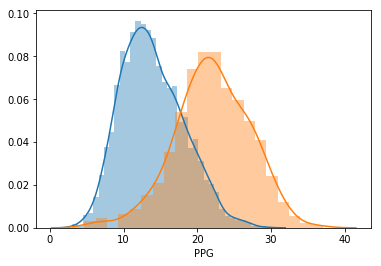

In [42]:
mvps = season_stats[season_stats['MVPSHARES'] > 0]
not_mvps = season_stats[season_stats['MVPSHARES'] == 0]

fig, ax = plt.subplots()
sns.distplot(not_mvps['PPG'], ax=ax)
sns.distplot(mvps['PPG'], ax=ax)

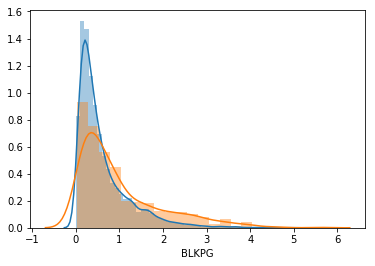

In [34]:
fig, ax = plt.subplots()
sns.distplot(not_mvps['BLKPG'], ax=ax)
sns.distplot(mvps['BLKPG'], ax=ax)

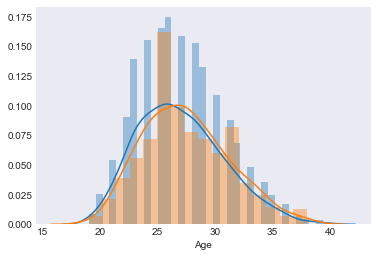

In [199]:
sns.distplot(not_mvps['Age'])
sns.distplot(mvps['Age'])

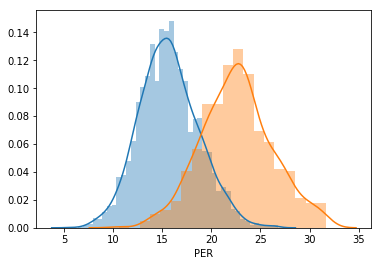

In [45]:
sns.distplot(not_mvps['PER'])
sns.distplot(mvps['PER'])

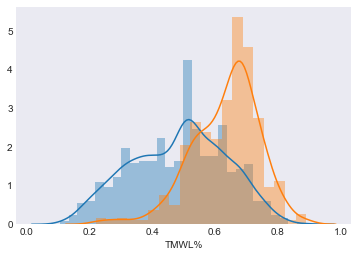

In [191]:
sns.distplot(not_mvps['TMWL%'])
sns.distplot(mvps['TMWL%'])

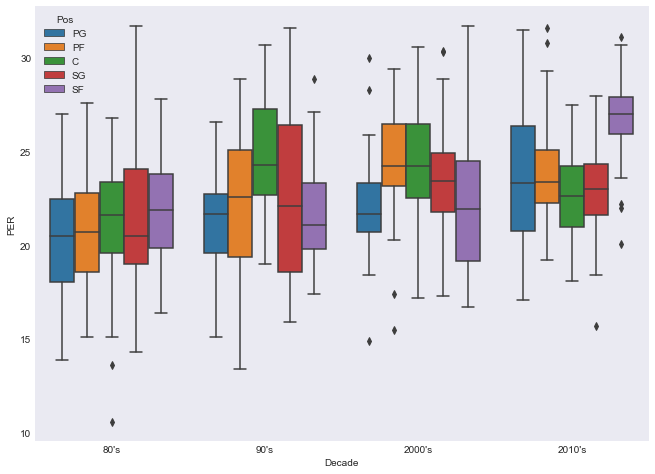

In [194]:
fig = plt.figure(figsize = (11,8))
sns.boxplot('Decade', 'PER', hue='Pos', data=mvps)

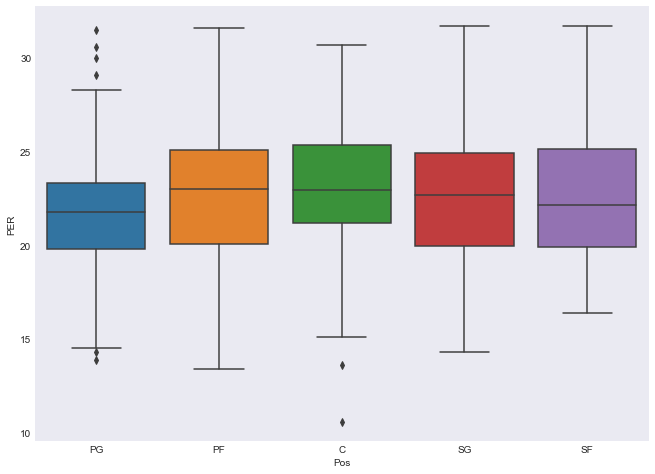

In [198]:
fig = plt.figure(figsize = (11,8))
sns.boxplot('Pos', 'PER', data=mvps)

In [36]:
season_2018 = pd.read_csv('2018_season.csv')

In [37]:
season_2018.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MVPSHARES,MVP,TMWL%
0,2018,Alex Abrines,SG,24,OKC,75,8,1134,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,0,1.3,1.0,2.2,0.094,0,-0.5,-1.7,-2.2,-0.1,115,291,0.395,84,221,0.380,31,70,0.443,0.540,39,46,0.848,26,88,114,28,38,8,25,124,353,0.0,0,0.585
1,2018,Quincy Acy,PF,27,BRK,70,8,1359,8.2,0.525,0.800,0.164,3.1,17.0,10.0,6.0,1.2,1.6,13.3,14.4,0,-0.1,1.1,1.0,0.036,0,-2.0,-0.2,-2.2,-0.1,130,365,0.356,102,292,0.349,28,73,0.384,0.496,49,60,0.817,40,217,257,57,33,29,60,149,411,0.0,0,0.341
2,2018,Steven Adams,C,24,OKC,76,76,2487,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.2,16.7,0,6.7,3.0,9.7,0.187,0,2.2,1.1,3.3,3.3,448,712,0.629,0,2,0.000,448,710,0.631,0.629,160,286,0.559,384,301,685,88,92,78,128,215,1056,0.0,0,0.585
3,2018,Bam Adebayo,C,20,MIA,69,19,1368,15.7,0.570,0.021,0.526,9.7,21.6,15.6,11.0,1.2,2.5,13.6,15.9,0,2.3,1.9,4.2,0.148,0,-1.6,1.8,0.2,0.8,174,340,0.512,0,7,0.000,174,333,0.523,0.512,129,179,0.721,118,263,381,101,32,41,66,138,477,0.0,0,0.537
4,2018,Arron Afflalo,SG,32,ORL,53,3,682,5.8,0.516,0.432,0.160,0.6,10.1,5.3,6.2,0.3,1.1,10.8,12.5,0,-0.1,0.2,0.1,0.009,0,-4.1,-1.8,-5.8,-0.7,65,162,0.401,27,70,0.386,38,92,0.413,0.485,22,26,0.846,4,62,66,30,4,9,21,56,179,0.0,0,0.305


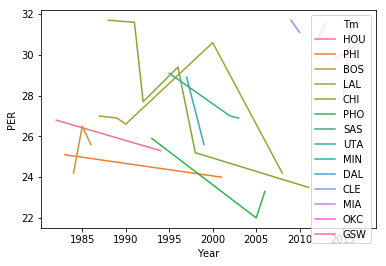

In [38]:
sns.lineplot(x='Year', y='PER', hue='Tm', data=mvp)

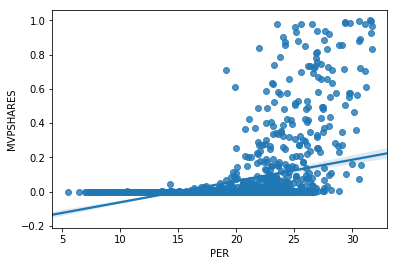

In [41]:
sns.regplot(mvps['PER'], mvps['MVPSHARES'])

In [129]:
season_stats.columns

Index(['Year', 'Decade', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'PER', 'TS%',
       '3PAr', 'FTr', 'TOV%', 'DWS', 'OBPM', 'DBPM', 'BPM', 'FT%', 'TOV',
       'MVPSHARES', 'MVP', 'TMWL%', 'MVP_Candidate', 'PPG', 'ASTPG', 'STLPG',
       'BLKPG', 'PFPG', 'TRPG', 'MPPG'],
      dtype='object')

In [163]:
from sklearn.preprocessing import StandardScaler

pca_features = season_stats.drop(['Tm', 'Pos', 'Decade', 'MVP', 'MVP_Candidate',
                                 'MVPSHARES', 'Player'], axis=1)
x = pca_features
y = season_stats.loc[:, ['MVPSHARES']].values

x = StandardScaler().fit_transform(x)

In [174]:
pca = pca.explained_variance_ratio_
np.sum(pca)

0.7320934809699623

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalcomponents = pca.fit_transform(x)
principalDF = pd.DataFrame(data = principalcomponents, columns = ['pc1', 'pc2', 'pc3', 'pc4',
                                                                 'pc5'] )
principalDF.head()

,pc1,pc2,pc3,pc4,pc5
0,0.501689,3.922580,-1.950692,2.668469,-3.742508
1,8.194548,1.356046,-1.051509,1.517272,2.301072
2,0.608502,-3.130201,-1.117341,0.570840,1.256380
3,-3.081459,1.080736,1.387832,1.729463,-0.456451
4,-0.248595,2.967230,-2.379075,1.896997,-4.678620


In [165]:
# Change to a gradient
finalDF = pd.concat([principalDF, season_stats[['MVPSHARES']]], axis = 1)
finalDF.head()

,pc1,pc2,MVPSHARES
0,0.501689,3.922580,NaN
1,8.194548,1.356046,NaN
2,0.608502,-3.130201,NaN
3,-3.081459,1.080736,NaN
4,-0.248595,2.967230,NaN


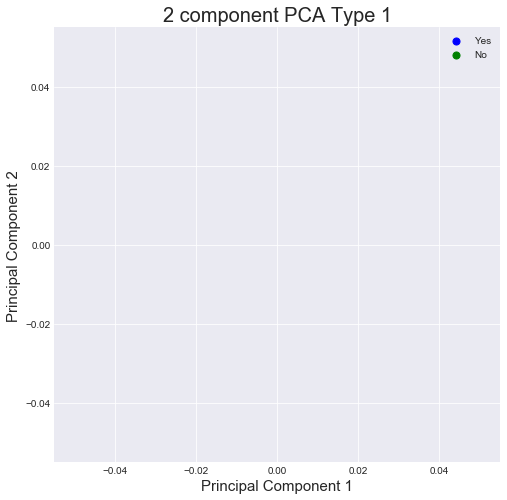

In [134]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA Type 1', fontsize = 20)

targets = ['Yes', 'No']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['MVP_Candidate'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'pc1'],
              finalDF.loc[indicesToKeep, 'pc2'],
              c = color,
              s = 50)
ax.legend(targets)
ax.grid()